In [92]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

**DICCIONARIOS CON LAS RUTAS**

In [93]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
audios = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        audios[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [94]:
processed = {fruit: [] for fruit in fruit_types}

for dirname, _, filenames in os.walk(root_dir):
    path = os.path.basename(dirname)
    if path == 'processed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            processed[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**CARACTERISTICAS DEL AUDIO**

In [171]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

**FUNCIONES**

In [96]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [97]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [98]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [62]:
def derivative(signal, duration):
    signal = signal.reshape(-1,)
    dy = np.gradient(signal, np.linspace(0, duration, len(signal)))
    return dy

In [99]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal

In [ ]:
def mean(audio_in):
    signal, sr, _ = load_audio(audio_in)
    frames = librosa.util.frame(signal, frame_length=512, hop_length=256)
    mean= np.mean(frames, axis=0)

# Crear un arreglo de tiempo para la visualización
    tiempo = librosa.times_like(mean, sr=sr, hop_length=256)
    
# Visualizar los valores medios en el tiempo
    plt.figure(figsize=(15, 4))
    #librosa.display.waveshow(signal, sr=sr, alpha=0.5)
    plt.plot(tiempo, mean, color='r', linewidth=2)
    plt.title('Señal de Audio y Valor Medio por Frame')
    plt.show()

In [ ]:
def med_filter(audio_in, audio_out, window = 3):
    signal, sr, _ = load_audio(audio_in)
    filtered = medfilt(signal, kernel_size=window)
    sf.write(audio_out, filtered, sr)

In [100]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [ ]:
def exponential_filter(audio_in, audio_out, alpha = 0.1):
    signal, sr, _ = load_audio(audio_in)
    filtered  = lfilter([1 - alpha], [1, -alpha], signal)
    sf.write(audio_out, filtered, sr)

In [347]:
def wiener_filter(signal, noise = 0.9):
    filtered = wiener(signal, noise = noise)
    return filtered

In [ ]:
def mean_movil_filter(audio_in, audio_out, ventana=3):
    # Definir el kernel de promedio móvil
    kernel = np.ones(ventana) / ventana

    signal, sr, _ = load_audio(audio_in)
    # Aplicar el filtro de promedio móvil
    filtered = convolve(signal, kernel, mode='same')
    
    sf.write(audio_out, filtered, sr)

In [101]:
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)


In [102]:
def smooth_envelope(signal, sr, cutoff_frequency=10.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)

In [251]:
def preemphasis(signal, coef=0.97):
    return np.append(signal[0], signal[1:] - coef * signal[:-1])

In [392]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

ESTE RECORTE CON LOS PARÁMETROS INDICADOR POR DEFECTO ANDA BASTANTE JJOYA. LO QUE SE PODRÍA AGREGAR DE ÚLTIMA ES UN FILTRO MAS DE WIENER QUE AL FRAN LE FUNCIONÓ Y PUEDE QUE A NOSOTROS TAMBIÉN NOS FUNCIONE

In [293]:
def trim(audio_in, audio_out, umbral = 0.295):
    signal, sr, duration = load_audio(audio_in)
    
    filtered = low_pass_filter(signal, sr, 1800)
    filtered = preemphasis(filtered, 0.999)

    rms_signal = rms(signal)

    rms_signal = normalize(rms_signal)
    drms = normalize(derivative(rms_signal, duration))

    audio_vector = time_vector(signal, duration)
    drms_vector = time_vector(drms, duration)

    left_index = np.argmax(np.abs(drms) > umbral)
    rigth_index = len(drms) - 1 - np.argmax(np.abs(np.flip(drms)) > umbral)

    left_time = drms_vector[left_index]
    rigth_time = drms_vector[rigth_index]

    mask_vector = audio_vector >= left_time

    audio_vector = audio_vector[mask_vector]
    trimed_signal = signal[mask_vector]

    mask_vector = audio_vector <= rigth_time

    audio_vector = audio_vector[mask_vector]
    trimed_signal = trimed_signal[mask_vector]

    sf.write(audio_out, trimed_signal, sr)

**FUNCIONES DE EFECTIVIDAD**

In [ ]:
def get_sphere(vectors):
    center = np.mean(vectors, axis = 0)
    center = center.reshape(1, -1)
    radius = cdist(center, vectors).max()     # Pairwise distance
    return radius, center

In [ ]:
def get_centers(features):
    centers = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        _, center = get_sphere(group)
        centers[fruit] = center
    return centers

In [ ]:
def get_radiuses(features):
    radiuses = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        radius, _ = get_sphere(group)
        radiuses[fruit] = radius
    return radiuses

In [ ]:
def get_overlaps(fruit_features):
    centers = get_centers(fruit_features)
    radiuses = get_radiuses(fruit_features)
    overlaps = dict.fromkeys(fruit_features.keys())
    
    # A dictionary of dictionarys. Keys, the fruit types
    for key in overlaps:
        # Each dictionary in the dictionary
        overlaps[key] = dict.fromkeys(fruit_types)
    
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            distancesAB = cdist(centers[fruit_types[i]], fruit_features[fruit_types[j]])
            distancesBA = cdist(centers[fruit_types[j]], fruit_features[fruit_types[i]])

            mask_distancesAB = distancesAB < radiuses[fruit_types[i]]
            mask_distancesBA = distancesBA < radiuses[fruit_types[j]]

            numberBinA = np.count_nonzero(mask_distancesAB)
            numberAinB = np.count_nonzero(mask_distancesBA)

            overlaps[fruit_types[i]][fruit_types[j]] = numberBinA
            overlaps[fruit_types[j]][fruit_types[i]] = numberAinB
    return overlaps # Each element is the number of vectors of one group in the sphere of another

In [ ]:
def get_components(centers, nc):
    pacum = np.zeros((1, centers[fruit_types[0]].shape[1]))
    pair_components = dict()
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            dif = centers[fruit_types[i]] - centers[fruit_types[j]]
            dist = cdist(centers[fruit_types[i]], centers[fruit_types[j]])
            difp = (dif**2)*100/(dist**2)
            pair_components[f"{fruit_types[i]}-{fruit_types[j]}"]= np.argsort(difp[0])[-nc:]
            pacum += difp
    index_max = np.argsort(pacum[0])[-nc:]
    #return np.sort(index_max)
    return index_max, pair_components

**PRINCIPAL**

**KNN**

In [ ]:
def knn(training, test, k_n):
    X = np.concatenate([v for v in training.values()], axis=0)
    y = np.concatenate([[k] * v.shape[0] for k, v in training.items()])

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear clasificador KNN
    knn_classifier = KNeighborsClassifier(n_neighbors = k_n)

    # Entrenar el clasificador
    knn_classifier.fit(X, y)

    # Predecir las etiquetas para los datos de prueba
    predicted_fruit = knn_classifier.predict(test)

    print(f'La fruta predicha para el nuevo audio es: {predicted_fruit[0]}')

**PLOTEO**

In [127]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [113]:
#3d
def plot_features3D(features:dict):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    ax = fig.add_subplot(111, projection='3d')
    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

    # configure labels
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

In [60]:
def plot_signal(signal, duration, name):
    time_vector = np.linspace(0, duration, len(signal))
    plt.figure(figsize=(15, 5))
    
    #plot
    #librosa.display.waveshow(signal)
    
    plt.plot(time_vector, signal, linestyle='-')
    
    # extra
    plt.title(f'Señal de Audio {name} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

In [61]:
#signal
def plot_audio(audio):
    signal, sr, duration = load_audio(audio)
    plot_signal(signal, duration, os.path.basename(audio))

**REPRESENTACION**

In [428]:
def print_dict(dic:dict):
    table = PrettyTable()
    for fruit, group in dic.items():
        table.add_row([fruit] + group)
        table.add_row([fruit] + [os.path.basename(audio) for audio in processed[fruit]])
    table.float_format = "0.3"
    print(table.get_string())

**Lo primero vamos a ver como funciona la función de recorte y los filtros**

In [ ]:
#trim de los audios
for type in audios:
    for i, _ in enumerate(audios[type]):
        wiener_filter(audios[type][i], processed[type][i], 10)

hemos visto que los filtros no funcionan muy bien.
Al oido puede que algunos se escuche que funcionan bien, pero no hacen en realidad mucho por el ruido que queremos eliminar de unos audios, que es el ruido impulsivo al inicio y al final del audio o ruido constante al principio y al final del audio. El que quiesieramos aminorar o eliminar para luego hacer un recorte limpio del audio

In [ ]:
#comparacion gráficas
for type in audios:
    for i, _ in enumerate(audios[type]):
        plot_signal(audios[type][i])
        plot_signal(processed[type][i])
        
        input()

problemas de ruido en pera6, banana6, banana7(un pico al final), banana8(ruido al inicio), manzana6(ruido al inicio), manzana7 (ruido al inicio), manzana8(ruido al final), naranja8(picos al final)

In [ ]:
for fruit, group in audios.items():
    for audio in group:
        rms_signal, duration = rms(audio)

        rms_signal = normalize(rms_signal)
        drms = normalize(derivative(rms_signal, duration))
        
        plot_audio(audio)
        
        plot_signal(rms_signal.reshape(-1,1), duration, "rms")
        plot_signal(drms, duration, 'drms/dt')
        input()

Probamos que es lo que pasa con la media de la señal de audio calculada por frames.
Como que queda medio feo con la función del librosas

In [ ]:
audio = audios['naranja'][6]
rms_signal, duration = rms(audio)

rms_signal = normalize(rms_signal)
drms = normalize(derivative(rms_signal, duration))

plot_audio(audio)
plot_signal(rms_signal.reshape(-1,1), duration, "rms")
plot_signal(drms, duration, 'drms/dt')

Probamos corte con la envolvente entonces.
Bueno, me di cuenta que también se podría llegar a hacer directamente con el rms el recorte porque da mas o menos la misma forma que da la envolvente sin tanta configuración. Con la RMS pareciera que hay unna buena descripción de la envolvente de la seña y además permite el recorte del ruido por identificación de un cambio importante en la derivada de la rms de la señal. El punto de corte se puede identificar cuando la derivada de la señal de rms deja de ser constante y pasa a tener un cambio importante. 44 es lo que le pusimos a la frecuencia de corte y anduvo copado. Osea dependia enrealidad del hopzise que quedo la mitad de un fram size de 4096

In [ ]:
audio = audios['pera'][6]
plot_audio(audio)
smooth_envelope(audio, cutoff_frequency = 44)

PROBAMOS EL FILTRO DE PREEMPHASIS
El filtro de prehempasis anda rejoya

In [ ]:
audio = audios['naranja'][6]
signal, sr, duration = load_audio(audio)
filtered = preemphasis(signal, 0.975)
#sf.write(processed['naranja'][6], filtered, sr)
plot_signal(normalize(signal), duration, os.path.basename(audio))
plot_signal(normalize(filtered), duration, 'filtered')

Ahora hay que probar el filtro de prehempasis con la derivada para tratar el corte

In [ ]:
indice = 6
fruit = 'naranja'
umbral = 0.295

audio_in = audios[fruit][indice]
audio_out = processed[fruit][indice]
signal,sr,_ = load_audio(audio_in)

audio_vector = time_vector(signal, duration)

filtered = low_pass_filter(signal, sr, 1800)
filtered = preemphasis(filtered, 0.999)
rms_signal = rms(filtered)

rms_signal = normalize(rms_signal)
drms = normalize(derivative(rms_signal, duration))

drms_vector = np.linspace(0, duration, len(drms))


left_index = np.argmax(np.abs(drms) > umbral)
rigth_index = len(drms) - 1 - np.argmax(np.abs(np.flip(drms)) > umbral)
print(left_index)
print(rigth_index)
left_time = drms_vector[left_index]
rigth_time = drms_vector[rigth_index]


mask_vector = audio_vector >= left_time
audio_vector = audio_vector[mask_vector]

trimed_signal = signal[mask_vector]

mask_vector = audio_vector <= rigth_time
audio_vector = audio_vector[mask_vector]
trimed_signal = trimed_signal[mask_vector]

# Seleccionar la porción de la señal entre los índices encontrados
#trimed = drms[left_index:rigth_index + 1]


plot_audio(audio_in)
plot_signal(rms_signal.reshape(-1,1), duration, "rms")
plot_signal(drms, duration, 'drms/dt')
#plot_signal(trimed_signal, left_time-rigth_time, 'trimed')
plot_signal(trimed_signal, rigth_time-left_time, f"trimed - {os.path.basename(audio_in)}")

In [378]:
ipd.Audio(trimed_signal,rate=sr)

PRUEBA DE LA APLICACIÓN DEL CORTE

In [294]:
#procesamiento del audio
for fruit, group in audios.items():
    for i, _ in enumerate(group):
        trim(audios[fruit][i], processed[fruit][i],0.295)

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


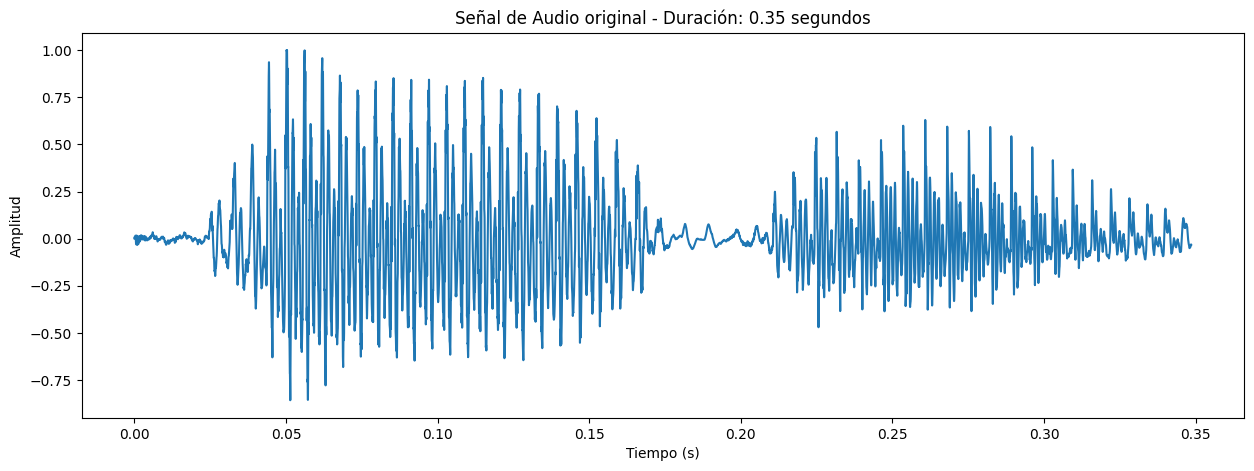

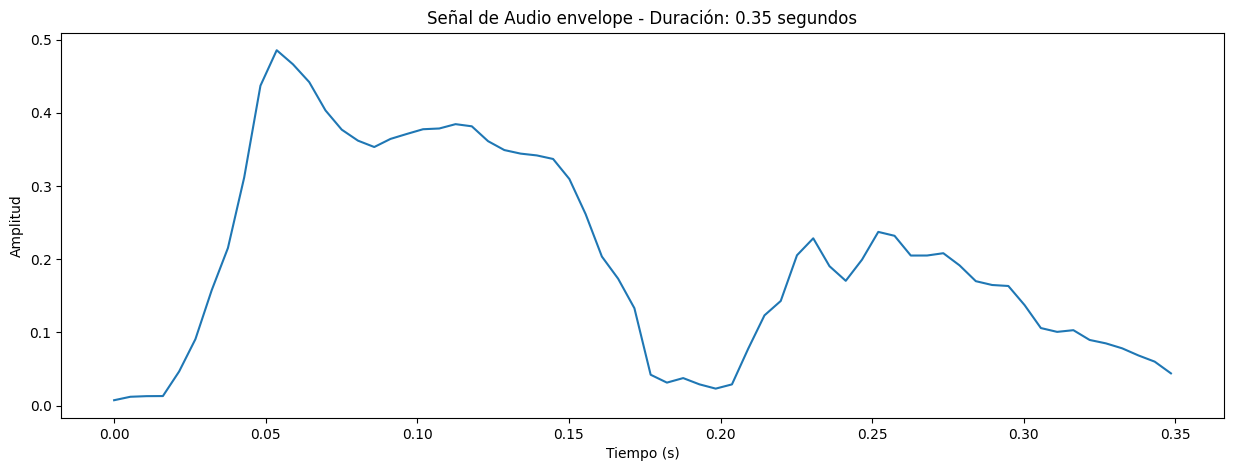

In [449]:
audio = processed['pera'][8]
signal,_,duration = load_audio(audio)
plot_signal(signal, duration, 'original')
plot_signal(rms(signal).reshape(-1,), duration, 'envelope')

VAMOS A PROBAR ENTONCES AHORA, CON LOS AUDIOS PROCESADOS EL TEMA DE LAS MEDIDAS AGREGADAS.

RMS: Aparentemente no se diferencian demasiado entre sí los grupos respecto de la razón entre el valor rms y la máxima amplitud de la señal. Aunque sí hay valores parecidos en un mismo grupo de audios, entre grupos los valores también son parecidos, sobre todo con las bananas, las naranjas y las manzanas. En cambio sí se nota un poco mas de diferenciación de las peras respecto de los grupos mencionados, teniendo los valores de RMS mayores. Otro problema que se puede notar que es que dentro de un mismo grupo hay fluctuaciones del RMS dependiendo de la intensidad de la persona al decir la fruta y del tipo de voz.

In [416]:
rmss = dict.fromkeys(fruit_types)
for fruit, audios in processed.items():
    rmss[fruit] = []
    for audio in audios:
        signal,_,_ = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
        rmss[fruit].append(float(audio_rms))
print_dict(rmss)

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


+---------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Field 1 |   Field 2    |    Field 3    |   Field 4    |   Field 5    |   Field 6    |   Field 7    |   Field 8    |   Field 9    |   Field 10   |   Field 11   |
+---------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|   pera  |     0.23     |      0.21     |     0.22     |     0.28     |     0.20     |     0.23     |     0.29     |     0.32     |     0.25     |     0.21     |
|   pera  |  pera1.wav   |   pera10.wav  |  pera2.wav   |  pera3.wav   |  pera4.wav   |  pera5.wav   |  pera6.wav   |  pera7.wav   |  pera8.wav   |  pera9.wav   |
|  banana |     0.14     |      0.29     |     0.17     |     0.16     |     0.15     |     0.16     |     0.26     |     0.17     |     0.26     |     0.15     |
|  banana | banana1.wa

COMPAREMOS AHORA RESPECTO DEL VALOR MEDIO DE LAS SEÑALES.
Como ya lo podiamos anticipar, el valor medio de todas las señales es cero.

In [417]:
means = dict.fromkeys(fruit_types)
for fruit, audios in processed.items():
    means[fruit] = []
    for audio in audios:
        signal,_,_ = load_audio(audio)
        audio_mean = np.mean(signal)/np.max(signal)
        means[fruit].append(float(audio_mean))
print_dict(means)

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


+---------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Field 1 |   Field 2    |    Field 3    |   Field 4    |   Field 5    |   Field 6    |   Field 7    |   Field 8    |   Field 9    |   Field 10   |   Field 11   |
+---------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|   pera  |     0.00     |     -0.00     |    -0.00     |    -0.00     |    -0.00     |    -0.00     |     0.00     |    -0.00     |     0.00     |     0.00     |
|   pera  |  pera1.wav   |   pera10.wav  |  pera2.wav   |  pera3.wav   |  pera4.wav   |  pera5.wav   |  pera6.wav   |  pera7.wav   |  pera8.wav   |  pera9.wav   |
|  banana |    -0.00     |     -0.00     |    -0.00     |    -0.00     |    -0.00     |     0.00     |    -0.00     |     0.00     |     0.00     |     0.00     |
|  banana | banana1.wa

AHORA RESPECTO DE LA INTEGRAL DE LA ENVOLVENTE DE LAS SEÑALES

Como que esto tampoco permite la diferenciación ni entre grupos ni la agrupación en cada grupo
.Con este tipo de medidas agrergadas, a lo sumo, podríamos hacer una separación de las peras con respecto al resto de los grupos. Sin embargo tampoco se logra buen arupamiento respecto de estas medidas entre los elementos de cada grupo

In [527]:
integrals = dict.fromkeys(fruit_types)
for fruit, audios in processed.items():
    integrals[fruit] = []
    for audio in audios:
        signal,sr,duration = load_audio(audio)
        smoothed = rms(signal)
        rms_smoothed = np.sqrt(np.mean(smoothed**2))/np.max(smoothed)
        
print_dict(integrals)

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


+---------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Field 1 |   Field 2    |    Field 3    |   Field 4    |   Field 5    |   Field 6    |   Field 7    |   Field 8    |   Field 9    |   Field 10   |   Field 11   |
+---------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|   pera  |    0.533     |     0.503     |    0.540     |    0.602     |    0.511     |    0.524     |    0.660     |    0.595     |    0.505     |    0.649     |
|   pera  |  pera1.wav   |   pera10.wav  |  pera2.wav   |  pera3.wav   |  pera4.wav   |  pera5.wav   |  pera6.wav   |  pera7.wav   |  pera8.wav   |  pera9.wav   |
|  banana |    0.434     |     0.535     |    0.484     |    0.435     |    0.640     |    0.658     |    0.570     |    0.444     |    0.580     |    0.571     |
|  banana | banana1.wa

Vamos con algunas medidas agregadas que vimos en internet y otras que recomendó el chaty.
Algo que concluí de observación es que las consonantes son partes silenciosas del audio y permiten la separación en silabas. Esto, permite la separación de por ejemplo naranjas de manzanas. Las manzanas tienen un silencio entre las primeras dos sílabas mientras que las naranjas tienen un silencio entre la penúltima y la última sílaba. Las bananas son mas bocalizadas y casi que no presentan silencio y las peras solamente tienen una separación entre las sílabas.

In [105]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [106]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

el naranja 6 con una frecuencia de corte de 140 ya da una señal no nula para el BER y es porque está re cogido. EN cambio para el resto de los audio a esa frecuencia de corte no se obsserva nada para el BER
Lo mismo empieza a pasar para el manzana 6 a una frecuencia de corte de 180.
Para los audios que no estan re cogidos, empezando por la manzana, ya se empieza a ver algo para el BER desde los 190
En el caso de la naranja tambien se empieza a ver para el caso del audio 1 porque el chabon que habkla tiene una voz mas gruesa que la verga

comparamos primero dentro de un mismo grupo a ver que onda.
Y la verdad que no se parecen mucho unos con respecto a otros. Las formas de las curvas son distintas en el tiempo y cuando se calcula la media de los BER también son distintas entre sí. Igual me di cuenta que es por un tema de la duración de los audios. y el hecho de que habria que normalizar. No sirve el BER, no agrupa bien los audios y no los separa bien entre sí. Pero puede ser que funcione

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


14.97310996055603
12.397683411836624
23.60306680202484
16.552919149398804
16.77824854850769
20.379209518432617
17.915594577789307
26.40068829059601
7.86101296544075
2.8662171214818954


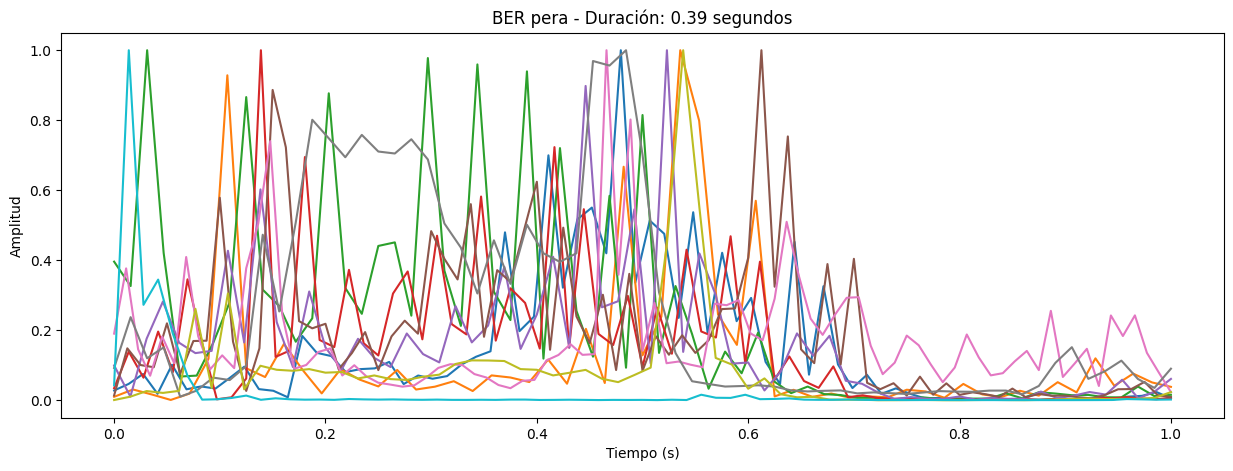

In [559]:
indice = 2
fruit = 'pera'
split_freq = 2800
#colors = dict(zip(fruit_types,['green','yellow','red','orange']))
plt.figure(figsize=(15, 5))
for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)
    BER = band_energy_ratio(spec, split_freq, sr)
    BER /= np.max(BER)
    print(np.mean(BER)*100)
    frames = range(len(BER))
    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    t/=t[-1]
    plt.plot(t, BER)
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

Probamos con el centroide espectral que me parece que no va a hacer nada porque es mas para la caracterización del sonido que del habla. Efectivamente no sirve pa una mierda. Podria llegar a funcionar

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


26.78345561713561
22.52067549072575
38.534176065892446
25.23774203575131
35.49121769370054
30.443242496577472
63.009646266490606
31.49220438153582
54.602787153132795
48.28256736094516


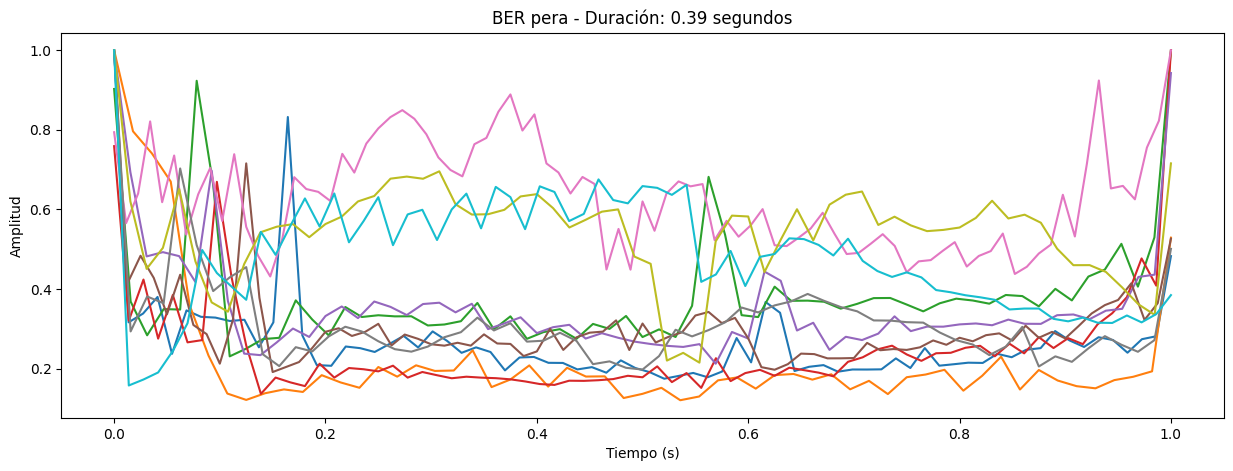

In [558]:
fruit = 'pera'
#colors = dict(zip(fruit_types,['green','yellow','red','orange']))
plt.figure(figsize=(15, 5))
for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    centroidal /= np.max(centroidal)
    print(np.mean(centroidal)*100)
    frames = range(len(centroidal))
    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    t/=t[-1]
    plt.plot(t, centroidal)
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

Ahora probamos con otra. Vamos con el zero croossing rate.
Lo primero que se puede observar es que para los audios re cogidos, al menos para los de la manzana la media del zero crossing rate es mas alta. Podria llegar a funcionar

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


42.65389082462253--0.0546875-naranja1.wav
29.844961240310074--0.0546875-naranja10.wav
45.64851207186973--0.05078125-naranja2.wav
51.869918699187004--0.048828125-naranja3.wav
44.750535659626564--0.052734375-naranja4.wav
49.14880201765448--0.05078125-naranja5.wav
36.11032929918379--0.033203125-naranja6.wav
30.64465898473995--0.07421875-naranja7.wav
51.20793787748059--0.037109375-naranja8.wav
53.50877192982455--0.0546875-naranja9.wav


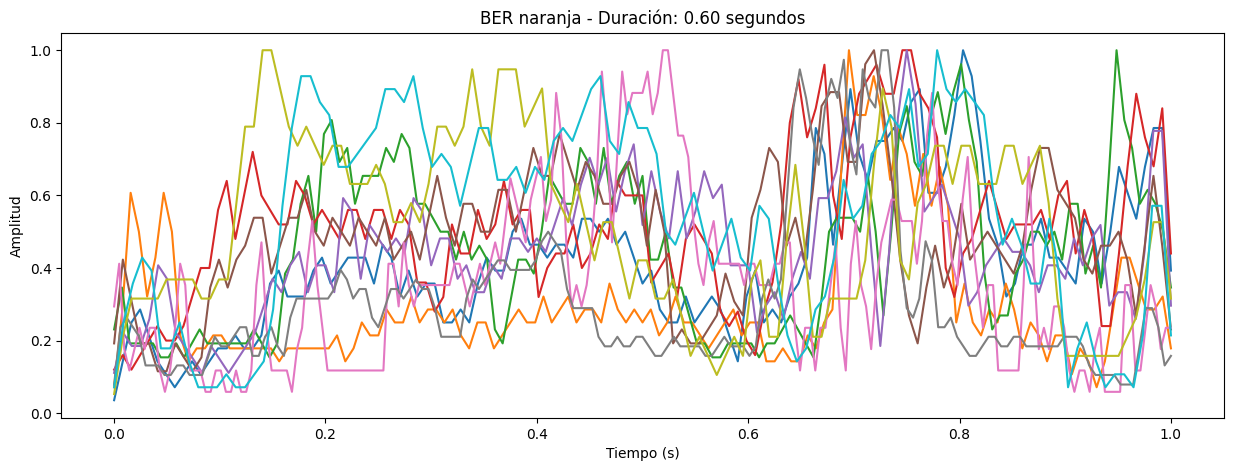

In [555]:
fruit = 'naranja'
#colors = dict(zip(fruit_types,['green','yellow','red','orange']))
plt.figure(figsize=(15, 5))
for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    filtered = low_pass_filter(signal, sr, 1800)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    max = np.max(zcr)
    zcr /= max
    print(f"{np.mean(zcr)*100}--{max}-{os.path.basename(audio)}")
    frames = range(len(zcr))
    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    t/=t[-1]
    plt.plot(t, zcr)
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

Vamos con otra característica el spectral flux

Aparentemente con esta medida se diferencian bastante bastante bien las frutas unas de otras pero además se puede ver que las curvas son similares en cada grupo de frutas. Eso luego de aplicar un filtro pasabajos con corte en 2000

In [139]:
def spectral_flux(signal):

    # Calcular el espectrograma de magnitudes
    spectrogram = np.abs(librosa.stft(signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))

    # Calcular el flujo espectral
    spectral_flux_values = np.sum(np.diff(spectrogram, axis=1)**2, axis=0)

    return spectral_flux_values

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


12.52 - banana1.wav - 1369.19
30.98 - banana10.wav - 636.83
9.96 - banana2.wav - 2259.30
19.58 - banana3.wav - 1058.40
24.70 - banana4.wav - 724.51
24.94 - banana5.wav - 610.10
26.38 - banana6.wav - 670.71
5.12 - banana7.wav - 2170.52
11.57 - banana8.wav - 270.19
29.51 - banana9.wav - 972.16


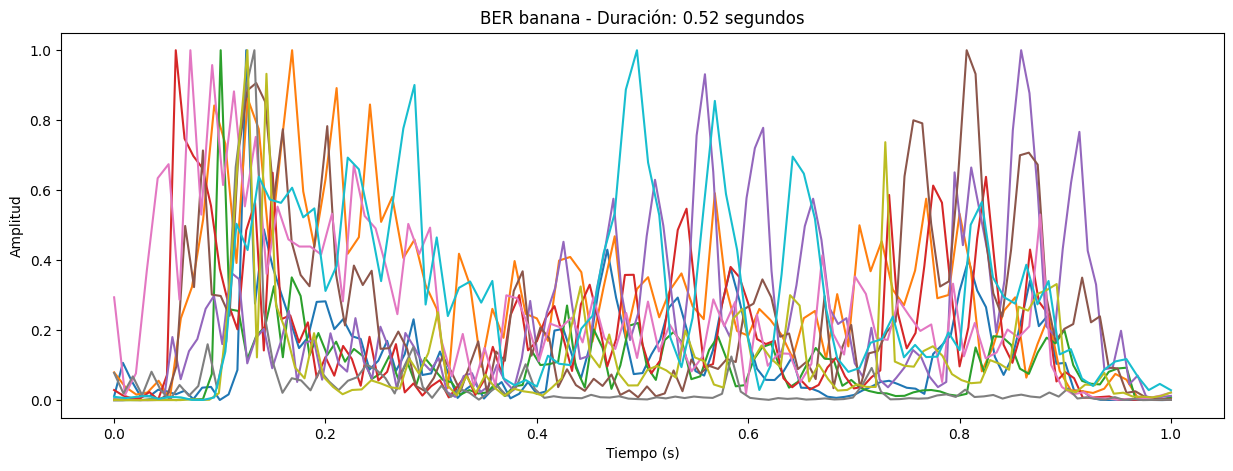

In [583]:
fruit = 'banana'
#colors = dict(zip(fruit_types,['green','yellow','red','orange']))
plt.figure(figsize=(15, 5))
for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    filtered = low_pass_filter(signal, sr, 2000)
    flux = spectral_flux(filtered)
    max = np.max(flux)
    flux /= np.max(flux)
    
    frames = range(len(flux))

    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    t/=t[-1]
    print("{:.2f}".format(np.mean(flux)*100) + f" - {os.path.basename(audio)} - " + "{:.2f}".format(max))
    plt.plot(t, flux)
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

Vamos con el spectral roll off. Puede ser posible que los diferencia pero es muy posible que no.

In [ ]:
# Cargar la señal de audio (reemplaza 'audio.wav' con el nombre de tu archivo)
fruit = 'naranja'
#colors = dict(zip(fruit_types,['green','yellow','red','orange']))
plt.figure(figsize=(15, 5))
for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    #spectrogram = np.abs(librosa.stft(signal, n_fft = FRAME_SIZE ,hop_length=HOP_SIZE))
    roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.2)[0]
    max = np.max(roll_off)
    roll_off /= np.max(roll_off)
    frames = range(len(roll_off))

    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    t/=t[-1]
    print("{:.2f}".format(np.mean(roll_off)*100) + f" - {os.path.basename(audio)} - " + "{:.2f}".format(max))
    plt.plot(t, roll_off)
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

Vamos a ver el tema del spectral spread.
Esto también puede llegar a funcionar

In [ ]:
fruit = 'naranja'
plt.figure(figsize=(15, 5))
for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    #spectrogram = np.abs(librosa.stft(signal, n_fft = FRAME_SIZE ,hop_length=HOP_SIZE))
    spread = librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)[0]

    max = np.max(spread)
    spread /= np.max(spread)
    frames = range(len(spread))

    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    t/=t[-1]
    print("{:.2f}".format(np.mean(spread)*100) + f" - {os.path.basename(audio)} - " + "{:.2f}".format(max))
    plt.plot(t, spread)
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

VOLVAMOS ENTONCES CON EL TEMA DE LOS MFFCS OTRA VEZ.

Evaluamos los primeros 5 MFCCS y comparamos la evolución de los mismos primero a través de un mismo grupo.
Las envolventes, al menos del coeficiente en la primera posición(0) se parecen mucho entre los audios de un mismo grupo.
Todo normalizado siempre. La diferencia es mas respecto de la forma de las curvas a lo largo del tiempo pero no en si de los valores agregados como por ejemplo la media de cada una de las componentes. En la tercera componente capaz que se nota mas diferencia
En la componente 4 se pueden llegar a diferencias en la media sobre todo en la naranja, pera respecto de los demas.
A lo sumo hay que probar con las primeras 3 componentes porque luego, al respecto de las demás componentes se produce demasiada dispersión dentro de cada grupo.

In [ ]:
fruit = 'naranja'
componente = 2
n_mfcc = 30
plt.figure(figsize=(15, 5))

for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    #spectrogram = np.abs(librosa.stft(signal, n_fft = FRAME_SIZE ,hop_length=HOP_SIZE))
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE, n_mfcc=n_mfcc)
    absolute = np.abs(mfccs)
    maxs = absolute.max(axis=1, keepdims=True)

    mfccs /= absolute.max(axis=1, keepdims=True)
    
    means = np.mean(mfccs, axis = 1)

    frames = range(mfccs.shape[1])

    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    t/=t[-1]

    print("{:.2f}".format(float(means[componente]*100)) + f" - {os.path.basename(audio)} - " + "{:.2f}".format(float(maxs[componente])))
    plt.plot(t, mfccs[componente,:])
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

En la primera componente de los deltas se pueden llegar a diferenciar.

En la segunda componente también pueden llegar a diferenciarse

In [ ]:
fruit = 'naranja'
componente = 36
n_mfcc = 50
plt.figure(figsize=(15, 5))

for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    #spectrogram = np.abs(librosa.stft(signal, n_fft = FRAME_SIZE ,hop_length=HOP_SIZE))
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfccs)

    absolute = np.abs(delta)
    maxs = absolute.max(axis=1, keepdims=True)

    delta /= absolute.max(axis=1, keepdims=True)
    
    means = np.mean(delta, axis = 1)

    frames = range(delta.shape[1])

    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    t/=t[-1]

    print("{:.2f}".format(float(means[componente]*100)) + f" - {os.path.basename(audio)} - " + "{:.2f}".format(float(maxs[componente])))
    plt.plot(t, delta[componente,:])
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

Bueno. La última medida que me parece que es la suficiente y me parece que es la final. Vimos que hay diferencias notalbes en cuento a las formas de las envolventes para los distintos audios y no solo de las envolventes sino que también en otras curvas como las compontenes de mfcc, la energía espectral, el ancho de banda, etc. Permiten identificar al audio dentro dl grupo y separar a los grupos unos de otros. La forma viene caracterízada, por el tiempo y por la amplitud. Es decir, la distribución de la amplitud a lo largo del tiempo. Eso, como medida agregada, se puede calcular, pienso, como el producto del tiempo relativo y la medida relativa, calculada por ejemplo en los máximos, o en los silencios, o en donde hay cambios de concavidad, etx.

Veamos con el producto de las envoventes otra vez y tal vez el producto de las duraciones de las partes habladas por la amplitud en esos intervaloz, la suma de todos esos elementos.

C:\Users\Juan\AppData\Local\Temp\ipykernel_5240\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


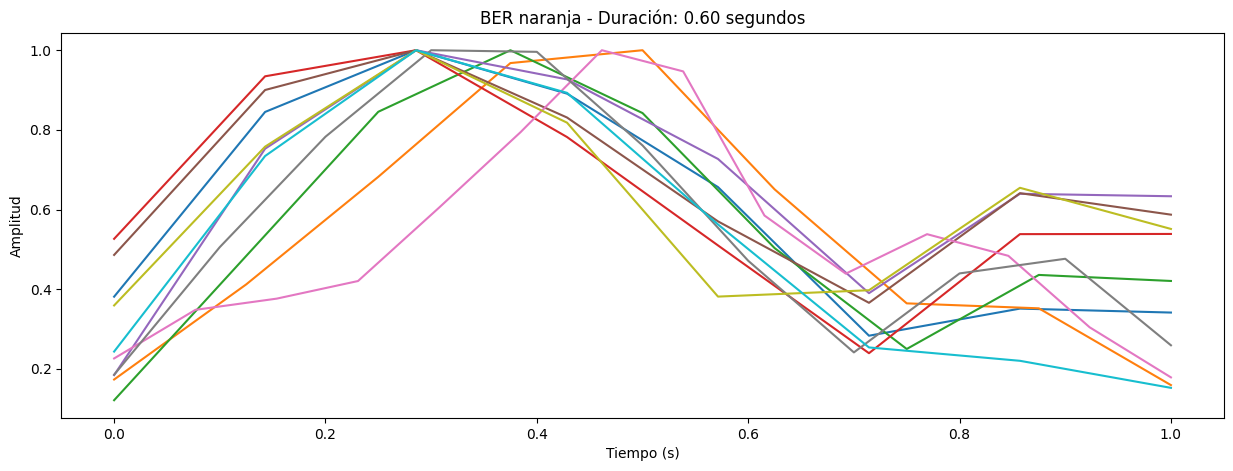

In [74]:
fruit = 'naranja'
plt.figure(figsize=(15, 5))

for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    RMS = rms(signal)
    
    #smoothed = smooth_envelope(signal, sr, 55)
    #t = time_vector(smoothed, duration)

    t = time_vector(RMS.reshape(-1,), duration)
    t /= duration

    plt.plot(t, normalize(RMS).reshape(-1,))
    plt.title(f'BER {fruit} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

Me voy a inventar una medida que se llama momento del audio. Que lo que hace es la suma de productos de las amplitudes normalizadas por los tiempos relativos a través de toda la duración del audio. Osea, básicamente es un producto escalar entre el vector de tiempo y el vector de amplitud y ta. Aparentemente no sirve para una bosta esto jejejeje

In [125]:
fruit = 'manzana'
plt.figure(figsize=(15, 5))

for audio in processed[fruit]:
    signal, sr, duration =  load_audio(audio)
    RMS = normalize(rms(signal))
    #smoothed = smooth_envelope(signal, sr, 80)
    #t = time_vector(smoothed, duration)

    t = time_vector(RMS.reshape(-1,), duration)
    
    t /= duration
    print("momentum:" + "{:.4}".format(np.dot(t, RMS.reshape(-1,))) + f" - {os.path.basename(audio)}")

C:\Users\Juan\AppData\Local\Temp\ipykernel_5240\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


momentum:24.7 - manzana1.wav
momentum:26.56 - manzana10.wav
momentum:29.03 - manzana2.wav
momentum:31.08 - manzana3.wav
momentum:22.48 - manzana4.wav
momentum:23.63 - manzana5.wav
momentum:29.52 - manzana6.wav
momentum:28.34 - manzana7.wav
momentum:22.09 - manzana8.wav
momentum:27.47 - manzana9.wav


<Figure size 1500x500 with 0 Axes>

PROBEMOS DIRECTAMENTE CON ALGUNAS A VER QUE PASA

C:\Users\Juan\AppData\Local\Temp\ipykernel_5240\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


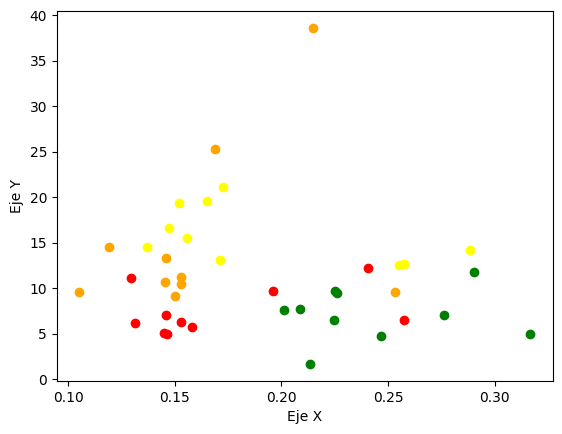

In [268]:
cutoff = 800
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal) # Es el ratio rms/max

        #spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #BER = band_energy_ratio(spec, split_freq, sr)
        #BER /= np.max(BER)
        #BER = np.mean(BER)

        #centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #centroidal /= np.max(centroidal)
        #centroidal = np.mean(centroidal)
        #smoothed = rms(signal)
        #smoothed = smoothed.reshape(-1,)
        #rms_smoothed = np.mean(smoothed)/np.max(smoothed)
        #filtered = low_pass_filter(signal, sr, cutoff)
        #feat = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #max = np.max(zcr)
        #flux = spectral_flux(filtered)
        #max = np.max(flux)
        #flux /= max
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        #smoothed /= np.max(smoothed)
        #N = 1
        #feat = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 5, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #feat = librosa.feature.delta(feat, order = 3)

        frames = range(len(feat))
        t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)

        absolute = np.abs(feat)
        #feat /= np.max(absolute)
        #absolute /= np.max(absolute)
        #feat = np.abs(feat)
        #row = feat[N,:]
        #row = np.abs(row)

        momentum = np.dot(t, absolute)
        #momentum/=np.sum(absolute)
        means = np.mean(feat)



        feature = np.array([[audio_rms, momentum]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

El BER no separa nada parece.
Tampoco la media de la rms smoothed o la rms de la rms smoothed
El spectral centroid pareciera que quisiera separar las naranjas de las manzanas pero casi nada. Porbe con el máximo y con la media del ZCR pero no separa. El momentum separa mucho mejor a la pera del resto de las frutas. Los momentos podrías llegar a separar bien capaz si utilizamos otras curvas y no las envolventes
El smoothed aparentemente permite una separación de las manzanas respecto de las demas frutas. El momentum de la primera componente de mel permite la separacón de las peras respecto del resto de las frutas.
La componente 1 de mel permite la separación de peras respecto de manzanas cuando se toma la media.
Me acabo de dar cuenta que el momentum anda joya para separar las peras de las manzanas ccomparado con utilizar solamente la media. Eso tanto para la componente 1 como para la 0. Pero funciona mejor para la 0. Hasta ahora solamente puedo observar la separación de las peras de los demas elementos cuando se utiliza el momentumy nada mas. El RMS pareciera separar medio bien.
El zero croosing rate de la señal sin filtrar permite la separación también de las peras respecto de las manzanas, pero además separa a las bananas de las manzanas (aunque quedan igual muy dispersas). Esto es del ZCR de la señal original sin filtrar y tomando el valor medio del ZCR. Cuando calculamos el momentum, lo que se observa es una separación otra vez entre las manzanas y peras y aparentemente las narnjas también tienden a separarse. Hay que ver que a veces el momentum funciona mejor sin la división por la suma de las componentes del vector ponderado. Por lo menos así, por ejemplo, con el momentum del ZCR se consigue una eseparación de las bananas respecto de lo demas

In [179]:
arr = np.array([1, 2, 3, 4])
arr1 = np.array([1, 2, 3, 4])
print(arr.shape)
print(arr1.shape)
print(np.dot(arr, arr1))


(4,)
(4,)
30
